In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Set the data directory
data_dir = '../input/face-expression-recognition-dataset/images/'

# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


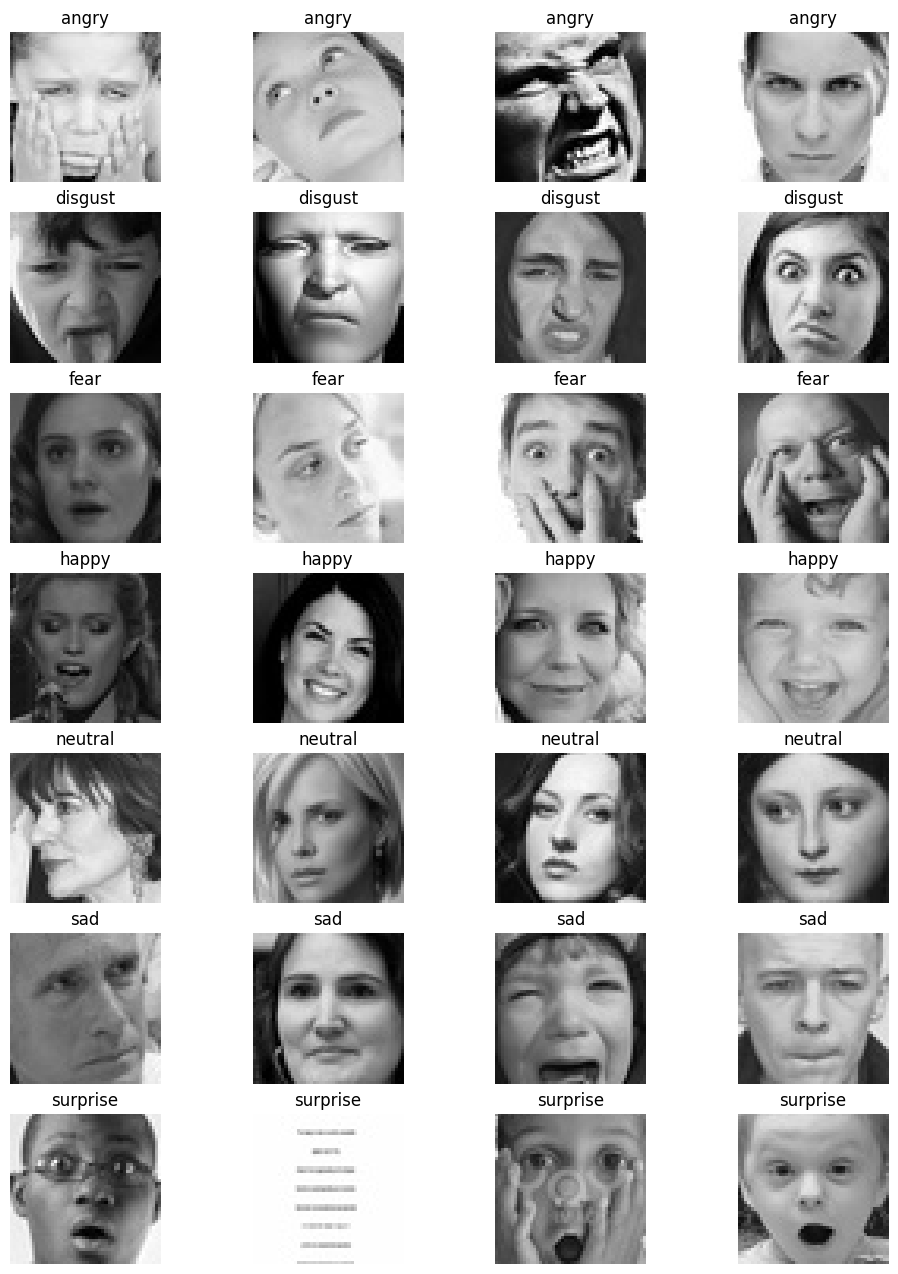

In [2]:
import random
import cv2
import matplotlib.pyplot as plt
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

fig, axes = plt.subplots(7, 4, figsize=(12, 16))
for i, emotion in enumerate(emotions):
    images = os.listdir(os.path.join(data_dir, 'train', emotion))
    random_images = random.sample(images, 4)
    for j, img_file in enumerate(random_images):
        img = cv2.imread(os.path.join(data_dir, 'train', emotion, img_file))
        axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, j].set_title(emotion)
        axes[i, j].axis('off')
plt.show()

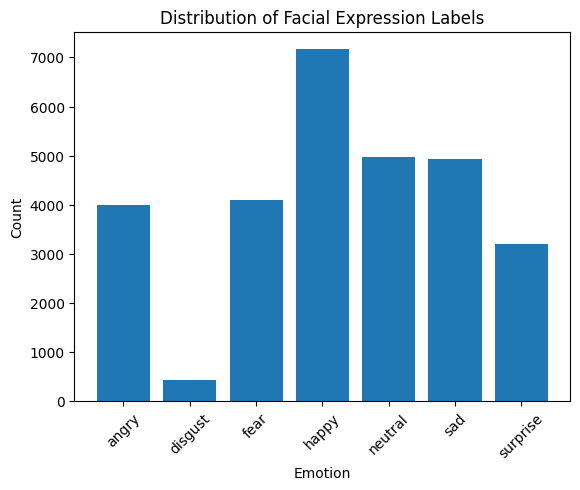

In [3]:

# Visualize the distribution of facial expression labels
import matplotlib.pyplot as plt

label_names = train_generator.class_indices.keys()
label_counts = [np.sum(train_generator.classes == i) for i in range(len(label_names))]

plt.bar(label_names, label_counts)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Facial Expression Labels')
plt.xticks(rotation=45)
plt.show()



In [4]:
# Model Hyperparameter Optimization using Random Search
from sklearn.model_selection import RandomizedSearchCV

def create_model(optimizer='adam', activation='relu', dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, input_shape=(48, 48, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

param_dist = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout_rate': [0.2, 0.3, 0.4]
}



In [5]:
best_accuracy = 0
best_params = None

for _ in range(5):  # Randomized search
    params = {key: np.random.choice(values) for key, values in param_dist.items()}
    model = create_model(optimizer=params['optimizer'], activation=params['activation'], dropout_rate=params['dropout_rate'])
    model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)
    
    # Convert continuous predictions to class labels
    validation_labels = validation_generator.classes  # Multiclass labels
    validation_predictions = model.predict(validation_generator)
    predicted_labels = np.argmax(validation_predictions, axis=1)
    
    accuracy = accuracy_score(validation_labels, predicted_labels)  # Calculate accuracy
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params


221/221 [==============================] - 9s 41ms/step


In [6]:
print("Best Hyperparameters:", best_params)

# Build and train the CNN model with the best hyperparameters
model = create_model(optimizer=best_params['optimizer'], activation=best_params['activation'], dropout_rate=best_params['dropout_rate'])

model.fit(train_generator, validation_data=validation_generator, epochs=5)



Best Hyperparameters: {'optimizer': 'rmsprop', 'activation': 'sigmoid', 'dropout_rate': 0.2}
Epoch 1/5
901/901 [==============================] - 77s 84ms/step - loss: 1.8322 - accuracy: 0.2397 - val_loss: 1.8117 - val_accuracy: 0.2583
Epoch 2/5
901/901 [==============================] - 75s 84ms/step - loss: 1.8163 - accuracy: 0.2483 - val_loss: 1.8089 - val_accuracy: 0.2583
Epoch 3/5
901/901 [==============================] - 75s 84ms/step - loss: 1.8142 - accuracy: 0.2484 - val_loss: 1.8097 - val_accuracy: 0.2583
Epoch 4/5
901/901 [==============================] - 73s 82ms/step - loss: 1.7972 - accuracy: 0.2497 - val_loss: 1.7738 - val_accuracy: 0.2601
Epoch 5/5
901/901 [==============================] - 73s 81ms/step - loss: 1.7483 - accuracy: 0.2829 - val_loss: 1.7005 - val_accuracy: 0.3095
